Create a pipeline by defining a number of functions which will for each of the five weather stations:

1) train and test a SARIMA model by using a series of an endogenous variable,

2) train and test a SARIMAX model by using a series of an endogenous variable and an exogenous variable, 

3) validation: return the predictions and observations of the two models above for the test set,

4) return the plot of the predictions and observations of the two models and their RMSE (root-mean-squared error) values.

In [1]:
# Check the versions of key python libraries for time series forecasting
# Import all relevant libraries related to time series forecasting and data visualization

# Check the versions of key python libraries for time series forecasting
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
import datetime

# Load specific time series forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from statsmodels.tsa.stattools import adfuller               # for the ADF statistic
from pmdarima import auto_arima                              # for determining ARIMA orders
from sklearn.metrics import mean_squared_error               
from math import sqrt

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Import tools and settings for data visualization
import itertools
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['text.color'] = 'k'

import seaborn as sns
sns.set()

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
print('All imports done!')

scipy: 1.3.1
numpy: 1.17.2
matplotlib: 3.0.3
pandas: 0.25.1
statsmodels: 0.10.1
sklearn: 0.21.3
All imports done!


In [16]:
# Load the grouped number of incidents by day
incidents_grouped=pd.read_csv('incidents_grouped.csv',header=None,index_col=0)
incidents_sdlf_grouped=pd.read_csv('incidents_sdlf_grouped.csv',header=None,index_col=0)
incidents_sdmf_grouped=pd.read_csv('incidents_sdmf_grouped.csv',header=None,index_col=0)
incidents_sdbf_grouped=pd.read_csv('incidents_sdbf_grouped.csv',header=None,index_col=0)
incidents_ramona_grouped=pd.read_csv('incidents_ramona_grouped.csv',header=None,index_col=0)
incidents_carlsbad_grouped=pd.read_csv('incidents_carlsbad_grouped.csv',header=None,index_col=0)

In [39]:
# Load weather feature data for each weather station
temp_sdlf = pd.read_csv('sdlf_weather_feature.csv', header=None, squeeze=True)
temp_sdmf = pd.read_csv('sdmf_weather_feature.csv', header=None, squeeze=True)
temp_sdbf = pd.read_csv('sdbf_weather_feature.csv', header=None, squeeze=True)
temp_ramona = pd.read_csv('ramona_weather_feature.csv', header=None, squeeze=True)
temp_carlsbad = pd.read_csv('carlsbad_weather_feature.csv', header=None,squeeze=True)

In [20]:
# Divide the time series to training, test and validation sets in the chronological order
def train_test_validation_split(series, name, validation_set, test_set):
    # validation_set: Number of rows in the validation set
    # test_set: Number of rows in the test set
    # name for the series to be used to name the csv files containing train, test and validation set 
    series = series.astype('float32')

    # Divide the series into a validation set and the rest
    split_point = len(series) - test_set
    series_dataset, test = series[0:split_point], series[split_point:]
    
    train_size = len(series_dataset)-validation_set
    train, validation = series_dataset[0:train_size], series_dataset[train_size:]
    series_dataset.to_csv(name+'_train_validation.csv',index=False)
    train.to_csv(name+'_train.csv',index=False)
    test.to_csv(name+'_test.csv',index=False)
    validation.to_csv(name+'_validation.csv',index=False)
    return print('Training Set: %d, Validation Set: %d, Test Set: %d' % (len(train), len(validation), len(test)))

In [21]:
train_test_validation_split(incidents_grouped,'incidents_grouped',181,184)
train_test_validation_split(incidents_sdlf_grouped,'incidents_sdlf_grouped',181,184)
train_test_validation_split(incidents_sdmf_grouped,'incidents_sdmf_grouped',181,184)
train_test_validation_split(incidents_sdbf_grouped,'incidents_sdbf_grouped',181,184)
train_test_validation_split(incidents_ramona_grouped,'incidents_ramona_grouped',181,184)
train_test_validation_split(incidents_carlsbad_grouped,'incidents_carlsbad_grouped',181,184)

Training Set: 730, Validation Set: 181, Test Set: 184
Training Set: 730, Validation Set: 181, Test Set: 184
Training Set: 730, Validation Set: 181, Test Set: 184
Training Set: 730, Validation Set: 181, Test Set: 184
Training Set: 730, Validation Set: 181, Test Set: 184
Training Set: 730, Validation Set: 181, Test Set: 184


In [41]:
train_test_validation_split(temp_sdlf,'sdlf_weather_feature',181,184)
train_test_validation_split(temp_sdmf,'sdmf_weather_feature',181,184)
train_test_validation_split(temp_sdbf,'sdbf_weather_feature',181,184)
train_test_validation_split(temp_ramona,'ramona_weather_feature',181,184)
train_test_validation_split(temp_carlsbad,'carlsbad_weather_feature',181,184)

Training Set: 730, Validation Set: 181, Test Set: 184
Training Set: 730, Validation Set: 181, Test Set: 184
Training Set: 730, Validation Set: 181, Test Set: 184
Training Set: 730, Validation Set: 181, Test Set: 184
Training Set: 730, Validation Set: 181, Test Set: 184


In [26]:
def hyperparameter_tuning(endog_name,exog_name=None, m=7,scoring='mse', out_of_sample_size=181):
    # Load and shape endogenous data for hyperparameter tuning 
    endog=pd.read_csv(endog_name+'_train_validation.csv', header=0, squeeze=True)
    endog=endog.values.reshape(-1,1)
    
    # Load and shape exogenous data for hyperparameter tuning
    if exog_name!=None:
        exog=pd.read_csv(exog_name+'_train_validation.csv', header=None, squeeze=True)
        exog=exog.values.reshape(-1,1)
    else:
        exog=None    
    return auto_arima(endog, exogenous=exog, seasonal=True, out_of_sample_size=out_of_sample_size, m=m,scoring=scoring).summary()   

## 1. San Diego Lindbergh Field Station:

In [29]:
# Hyperparameter tuning with only incident data using SARIMAX model (no exogenous variables are used.)
hyperparameter_tuning('incidents_sdlf_grouped')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  911
Model:             SARIMAX(1, 1, 2)x(1, 0, 1, 7)   Log Likelihood               -3861.447
Date:                           Mon, 07 Oct 2019   AIC                           7736.895
Time:                                   10:02:04   BIC                           7770.589
Sample:                                        0   HQIC                          7749.759
                                           - 911                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5.009e-06   4.69e-05     -0.107      0.915   -9.69e-05    8.69e-05
ar.L1          0.8706      0.045     19.395      0.000       0.783       0.959
ma.L1         -1.6810      0.060    -27.918      0.000      -1.799      -1.563
ma.L2          0.6854      0.058     11.764      0.000       0.571       0.800
ar.S.L7        0.9938      0.008    117.554      0.000       0.977       1.010
ma.S.L7       -0.9686      0.024    -40.380      0.000      -1.016      -0.922
sigma2       281.8895     14.084     20.015      0.000     254.285     309.494
===================================================================================
Ljung-Box (Q):                       43.17   Jarque-Bera (JB):                 4.49
Prob(Q):                              0.34   Prob(JB):                         0.11
Heteroskedasticity (H):               1.07   Skew:                             0.11
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# Hyperparameter tuning with incident and weather data using SARIMAX model
hyperparameter_tuning('incidents_sdlf_grouped','sdlf_weather_feature')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  911
Model:             SARIMAX(2, 1, 2)x(1, 0, 1, 7)   Log Likelihood               -3848.058
Date:                           Mon, 07 Oct 2019   AIC                           7714.116
Time:                                   09:59:42   BIC                           7757.437
Sample:                                        0   HQIC                          7730.657
                                           - 911                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.994e-06      0.000      0.030      0.976      -0.000       0.000
x1             0.5266      0.104      5.064      0.000       0.323       0.730
ar.L1          0.4080      0.287      1.421      0.155      -0.155       0.971
ar.L2          0.0690      0.056      1.222      0.222      -0.042       0.180
ma.L1         -1.2297      0.286     -4.297      0.000      -1.791      -0.669
ma.L2          0.2698      0.266      1.015      0.310      -0.251       0.791
ar.S.L7        0.9980      0.005    185.356      0.000       0.987       1.009
ma.S.L7       -0.9834      0.023    -42.312      0.000      -1.029      -0.938
sigma2       255.6019     12.551     20.365      0.000     231.002     280.202
===================================================================================
Ljung-Box (Q):                       47.26   Jarque-Bera (JB):                 6.01
Prob(Q):                              0.20   Prob(JB):                         0.05
Heteroskedasticity (H):               1.08   Skew:                             0.16
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 2. San Diego Montgomery Field Station:

In [30]:
# Hyperparameter tuning with only incident data using SARIMAX model (no exogenous variables are used.)
hyperparameter_tuning('incidents_sdmf_grouped')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  911
Model:             SARIMAX(2, 0, 4)x(2, 0, 2, 7)   Log Likelihood               -3654.525
Date:                           Mon, 07 Oct 2019   AIC                           7333.050
Time:                                   10:06:18   BIC                           7390.825
Sample:                                        0   HQIC                          7355.108
                                           - 911                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     91.8745     36.488      2.518      0.012      20.358     163.391
ar.L1         -1.4913      0.180     -8.287      0.000      -1.844      -1.139
ar.L2         -0.7613      0.180     -4.235      0.000      -1.114      -0.409
ma.L1          1.6014      0.179      8.941      0.000       1.250       1.952
ma.L2          1.0220      0.198      5.165      0.000       0.634       1.410
ma.L3          0.2722      0.061      4.456      0.000       0.152       0.392
ma.L4          0.1238      0.033      3.765      0.000       0.059       0.188
ar.S.L7        0.0433      0.151      0.287      0.774      -0.252       0.339
ar.S.L14       0.7400      0.125      5.910      0.000       0.495       0.985
ma.S.L7        0.1304      0.149      0.872      0.383      -0.163       0.423
ma.S.L14      -0.6568      0.102     -6.442      0.000      -0.857      -0.457
sigma2       169.2795      8.409     20.131      0.000     152.799     185.760
===================================================================================
Ljung-Box (Q):                       55.86   Jarque-Bera (JB):                 6.22
Prob(Q):                              0.05   Prob(JB):                         0.04
Heteroskedasticity (H):               0.80   Skew:                             0.13
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Hyperparameter tuning with incident and temperature data using SARIMAX model
hyperparameter_tuning('incidents_sdmf_grouped','sdmf_weather_feature')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  911
Model:             SARIMAX(5, 0, 1)x(2, 0, 2, 7)   Log Likelihood               -3628.888
Date:                           Mon, 07 Oct 2019   AIC                           7283.775
Time:                                   10:10:59   BIC                           7346.364
Sample:                                        0   HQIC                          7307.671
                                           - 911                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.8645      3.417      1.424      0.155      -1.833      11.562
x1             0.2294      0.061      3.763      0.000       0.110       0.349
ar.L1         -0.7655      0.171     -4.471      0.000      -1.101      -0.430
ar.L2          0.1855      0.042      4.372      0.000       0.102       0.269
ar.L3          0.1297      0.046      2.812      0.005       0.039       0.220
ar.L4          0.0713      0.043      1.665      0.096      -0.013       0.155
ar.L5          0.0021      0.038      0.054      0.957      -0.073       0.078
ma.L1          0.8656      0.166      5.200      0.000       0.539       1.192
ar.S.L7        0.1206      0.108      1.116      0.265      -0.091       0.333
ar.S.L14       0.8513      0.105      8.118      0.000       0.646       1.057
ma.S.L7       -0.0257      0.095     -0.272      0.786      -0.211       0.160
ma.S.L14      -0.8449      0.082    -10.270      0.000      -1.006      -0.684
sigma2       168.6926      8.698     19.394      0.000     151.644     185.741
===================================================================================
Ljung-Box (Q):                       44.69   Jarque-Bera (JB):                 4.15
Prob(Q):                              0.28   Prob(JB):                         0.13
Heteroskedasticity (H):               0.78   Skew:                             0.13
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 3. San Diego Brown Field Station:

In [33]:
# Hyperparameter tuning with only incident data using SARIMAX model (no exogenous variables are used.)
hyperparameter_tuning('incidents_sdbf_grouped')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  911
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -3036.814
Date:                           Mon, 07 Oct 2019   AIC                           6087.629
Time:                                   10:14:03   BIC                           6121.331
Sample:                                        0   HQIC                          6100.496
                                           - 911                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     26.1206      1.994     13.096      0.000      22.212      30.030
ar.L1          0.0670      0.032      2.070      0.038       0.004       0.130
ar.L2          0.1058      0.031      3.463      0.001       0.046       0.166
ar.L3          0.0677      0.034      1.997      0.046       0.001       0.134
ar.S.L7        0.0516      0.033      1.569      0.117      -0.013       0.116
ar.S.L14       0.0755      0.033      2.301      0.021       0.011       0.140
sigma2        46.0135      2.210     20.823      0.000      41.682      50.345
===================================================================================
Ljung-Box (Q):                       30.16   Jarque-Bera (JB):                13.86
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.30
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Hyperparameter tuning with incident and temperature data using SARIMAX model
hyperparameter_tuning('incidents_sdbf_grouped','sdbf_weather_feature')

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  911
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -3033.883
Date:                Mon, 07 Oct 2019   AIC                           6077.765
Time:                        10:12:53   BIC                           6101.838
Sample:                             0   HQIC                          6086.956
                                - 911                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.9425      1.616      1.821      0.069      -0.225       6.110
x1             0.0774      0.033      2.365      0.018       0.013       0.142
ar.L1          0.9126      0.047     19.276      0.000       0.820       1.005
ma.L1         -0.8370      0.064    -13.123      0.000      -0.962      -0.712
sigma2        45.7309      2.230     20.504      0.000      41.360      50.102
===================================================================================
Ljung-Box (Q):                       28.76   Jarque-Bera (JB):                11.17
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.27
Prob(H) (two-sided):                  0.71   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 4. Ramona Station:

In [34]:
# Hyperparameter tuning with only incident data using SARIMAX model (no exogenous variables are used.)
hyperparameter_tuning('incidents_ramona_grouped')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  911
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2479.232
Date:                           Mon, 07 Oct 2019   AIC                           4968.463
Time:                                   10:14:58   BIC                           4992.536
Sample:                                        0   HQIC                          4977.654
                                           - 911                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.2682      1.783      1.272      0.203      -1.226       5.762
ma.L1          0.0357      0.033      1.072      0.284      -0.030       0.101
ar.S.L7        0.8231      0.139      5.913      0.000       0.550       1.096
ma.S.L7       -0.7673      0.156     -4.933      0.000      -1.072      -0.462
sigma2        13.5138      0.652     20.731      0.000      12.236      14.791
===================================================================================
Ljung-Box (Q):                       48.57   Jarque-Bera (JB):                 7.79
Prob(Q):                              0.17   Prob(JB):                         0.02
Heteroskedasticity (H):               0.94   Skew:                             0.22
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# Hyperparameter tuning with incident and temperature data using SARIMAX model
hyperparameter_tuning('incidents_ramona_grouped','ramona_weather_feature')

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  911
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2476.162
Date:                Mon, 07 Oct 2019   AIC                           4962.323
Time:                        10:15:25   BIC                           4986.396
Sample:                             0   HQIC                          4971.514
                                - 911                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4290      0.356      1.205      0.228      -0.269       1.127
x1         -2.443e-05      0.013     -0.002      0.999      -0.026       0.026
ar.L1          0.9666      0.027     35.752      0.000       0.914       1.020
ma.L1         -0.9314      0.037    -24.936      0.000      -1.005      -0.858
sigma2        13.4384      0.646     20.808      0.000      12.173      14.704
===================================================================================
Ljung-Box (Q):                       40.32   Jarque-Bera (JB):                 7.64
Prob(Q):                              0.46   Prob(JB):                         0.02
Heteroskedasticity (H):               0.95   Skew:                             0.22
Prob(H) (two-sided):                  0.67   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 5. Carlsbad Station:

In [36]:
# Hyperparameter tuning with only incident data using SARIMAX model (no exogenous variables are used.)
hyperparameter_tuning('incidents_carlsbad_grouped')

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  911
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1609.277
Date:                Mon, 07 Oct 2019   AIC                           3224.554
Time:                        10:17:48   BIC                           3238.994
Sample:                             0   HQIC                          3230.067
                                - 911                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.000      3.366      0.001       0.000       0.001
ma.L1         -0.9999      0.203     -4.933      0.000      -1.397      -0.603
sigma2         1.9969      0.411      4.855      0.000       1.191       2.803
===================================================================================
Ljung-Box (Q):                       52.40   Jarque-Bera (JB):               107.20
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.76
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
# Hyperparameter tuning with incident and temperature data using SARIMAX model
hyperparameter_tuning('incidents_carlsbad_grouped','carlsbad_weather_feature')

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  911
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1607.139
Date:                Mon, 07 Oct 2019   AIC                           3222.278
Time:                        10:23:54   BIC                           3241.532
Sample:                             0   HQIC                          3229.630
                                - 911                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.000      3.347      0.001       0.000       0.001
x1            -0.0219      0.011     -2.037      0.042      -0.043      -0.001
ma.L1         -0.9996      0.030    -32.889      0.000      -1.059      -0.940
sigma2         1.9887      0.105     19.021      0.000       1.784       2.194
===================================================================================
Ljung-Box (Q):                       50.80   Jarque-Bera (JB):               109.34
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.76
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Validation:

In [49]:
# Validate univariate and multivariate models on the test set
def validation(endog_name, exog_name,order_u,seasonal_order_u,order_m,seasonal_order_m):
    # Load and shape endogenous data for hyperparameter tuning 
    endog_train_valid=pd.read_csv(endog_name+'_train_validation.csv', header=0, squeeze=True)
    endog_train_valid=endog_train_valid.values.reshape(-1,1)
    endog_test=pd.read_csv(endog_name+'_test.csv', header=0, squeeze=True)
    endog_test=endog_test.values.reshape(-1,1)
    
    # Load and shape exogenous data for hyperparameter tuning 
    exog_train_valid=pd.read_csv(exog_name+'_train_validation.csv', header=None, squeeze=True)
    exog_train_valid=exog_train_valid.values.reshape(-1,1)
    exog_test=pd.read_csv(exog_name+'_test.csv', header=None, squeeze=True)
    exog_test=exog_test.values.reshape(-1,1)
    
    # Prepare the data for walk-forward validation
    history_endog_u = [x for x in endog_train_valid]
    history_endog_m = [x for x in endog_train_valid]
    history_exog = [x for x in exog_train_valid]
    future_exog=[x for x in exog_test]
    
    # Predictions for the univariate model 
    predictions_u = list()
    # Predictions for the multivariate model
    predictions_m=list()

    # Report performance for the univariate model
    for i in range(len(endog_test)):
        model_u = SARIMAX(history_endog_u,order=order_u,seasonal_order=seasonal_order_u,enforce_invertibility=False, initialization='approximate_diffuse')
        model_u_fit = model_u.fit()
        # predict
        yhat = model_u_fit.predict(len(history_endog_u),len(history_endog_u))[0]
        predictions_u.append(yhat)
        # observation
        obs = endog_test[i]
        history_endog_u.append(obs)
    
    # Report performance for the univariate model
    rmse_u = sqrt(mean_squared_error(endog_test, predictions_u))
    print('RMSE for the Univariate Model: %.3f' % rmse_u)    
    
    # Report performance for the multivariate model
    for i in range(len(endog_test)):
        model_m = SARIMAX(history_endog_m,exog=history_exog, order=order_m,seasonal_order=seasonal_order_m,enforce_invertibility=False, initialization='approximate_diffuse')
        model_m_fit  = model_m.fit()
        # predict
        exog_forecast = np.array(future_exog[i]).reshape(1,1)
        yhat = model_m_fit.predict(len(history_endog_m),len(history_endog_m),exog=exog_forecast)[0]
        predictions_m.append(yhat)
        # observation
        obs = endog_test[i]
        obs_exog=exog_test[i]
        history_endog_m.append(obs)
        history_exog.append(obs_exog)
   
    # Report performance for the multivariate model
    rmse_m = sqrt(mean_squared_error(endog_test, predictions_m))
    print('RMSE for the Multivariate Model: %.3f' % rmse_m)
    predictions_u_name=pd.Series(predictions_u, name='Univariate Predictions')
    predictions_m_name=pd.Series(predictions_m, name='Multivariate Predictions')
    predictions_u_name.to_csv(endog_name+'_predictions_univariate.csv',index=False)
    predictions_m_name.to_csv(endog_name+'_predictions_multivariate.csv',index=False)

In [50]:
# Validation for the San Diego Lindbergh Field Station data
validation('incidents_sdlf_grouped','sdlf_weather_feature',(1,1,2),(1,0,1,7),(2,1,2),(1,0,1,7))

RMSE for the Univariate Model: 17.072
RMSE for the Multivariate Model: 16.985


In [52]:
# Validation for the San Diego Montgomery Field Station data
validation('incidents_sdmf_grouped','sdmf_weather_feature',(2,0,4),(2,0,2,7),(5,0,1),(2,0,2,7))

RMSE for the Univariate Model: 12.181
RMSE for the Multivariate Model: 12.557


In [53]:
# Validation for the San Diego Brown Field Station data
# Keep the same seasonality variables in the multivariate model if there is any seasonality in the univariate model
validation('incidents_sdbf_grouped','sdbf_weather_feature',(3,0,0),(2,0,0,7),(1,0,1),(2,0,0,7))

RMSE for the Univariate Model: 7.440
RMSE for the Multivariate Model: 6.593


In [54]:
# Validation for the Ramona Station data
# Keep the same seasonality variables in the multivariate model if there is any seasonality in the univariate model
validation('incidents_ramona_grouped','ramona_weather_feature',(0,0,1),(1,0,1,7),(1,0,1),(1,0,1,7))

RMSE for the Univariate Model: 3.795
RMSE for the Multivariate Model: 3.917


In [55]:
# Validation for the Carlsbad Station data
validation('incidents_carlsbad_grouped','carlsbad_weather_feature',(0,1,1),(0,0,0,0),(0,1,1),(0,0,0,0))

RMSE for the Univariate Model: 1.521
RMSE for the Multivariate Model: 1.520


The model performs better than the benchmark case but we will try other parameters for the ARIMA model to see if we can do even better:

In [56]:
endog_test=pd.read_csv('incidents_grouped'+'_test.csv', header=0, squeeze=True)

# Convert the numpy arrays of observed and predicted values of the test set into series
predictions_u_sdlf=pd.read_csv('incidents_sdlf_grouped'+'_predictions_univariate.csv', header=None, squeeze=True)
predictions_m_sdlf=pd.read_csv('incidents_sdlf_grouped'+'_predictions_multivariate.csv', header=None, squeeze=True)
# Convert the numpy arrays of observed and predicted values of the test set into series
predictions_u_sdmf=pd.read_csv('incidents_sdmf_grouped'+'_predictions_univariate.csv', header=None, squeeze=True)
predictions_m_sdmf=pd.read_csv('incidents_sdmf_grouped'+'_predictions_multivariate.csv', header=None, squeeze=True)
# Convert the numpy arrays of observed and predicted values of the test set into series
predictions_u_sdbf=pd.read_csv('incidents_sdbf_grouped'+'_predictions_univariate.csv', header=None, squeeze=True)
predictions_m_sdbf=pd.read_csv('incidents_sdbf_grouped'+'_predictions_multivariate.csv', header=None, squeeze=True)
# Convert the numpy arrays of observed and predicted values of the test set into series
predictions_u_ramona=pd.read_csv('incidents_ramona_grouped'+'_predictions_univariate.csv', header=None, squeeze=True)
predictions_m_ramona=pd.read_csv('incidents_ramona_grouped'+'_predictions_multivariate.csv', header=None, squeeze=True)
# Convert the numpy arrays of observed and predicted values of the test set into series
predictions_u_carlsbad=pd.read_csv('incidents_carlsbad_grouped'+'_predictions_univariate.csv', header=None, squeeze=True)
predictions_m_carlsbad=pd.read_csv('incidents_carlsbad_grouped'+'_predictions_multivariate.csv', header=None, squeeze=True)

In [57]:
predictions_u=predictions_u_sdlf+predictions_u_sdmf+predictions_u_sdbf+predictions_u_ramona+predictions_u_carlsbad
predictions_m=predictions_m_sdlf+predictions_m_sdmf+predictions_m_sdbf+predictions_m_ramona+predictions_m_carlsbad

# Report performance for the univariate model
rmse_u = sqrt(mean_squared_error(endog_test, predictions_u))
print('RMSE for the Univariate Model: %.3f' % rmse_u) 
# Report performance for the univariate model
rmse_m = sqrt(mean_squared_error(endog_test, predictions_m))
print('RMSE for the Multivariate Model: %.3f' % rmse_m)            

RMSE for the Univariate Model: 23.628
RMSE for the Multivariate Model: 22.392


In [72]:
# Convert the numpy arrays of observed and predicted values of the test set into series
endog_name='incidents_grouped'
endog_test=pd.read_csv(endog_name+'_test.csv', header=0, squeeze=True)
test_name=pd.Series(endog_test, name='Test Set Observations')
predictions_u_name=pd.Series(predictions_u, name='univariate_predictions')
predictions_m_name=pd.Series(predictions_m, name='multivariate_predictions')
# Plot predictions against known values
title='Observed versus Predicted Number of Incidents from March 1st, 2019 to August 31st, 2019'
ylabel='Number of Incidents'
xlabel=''

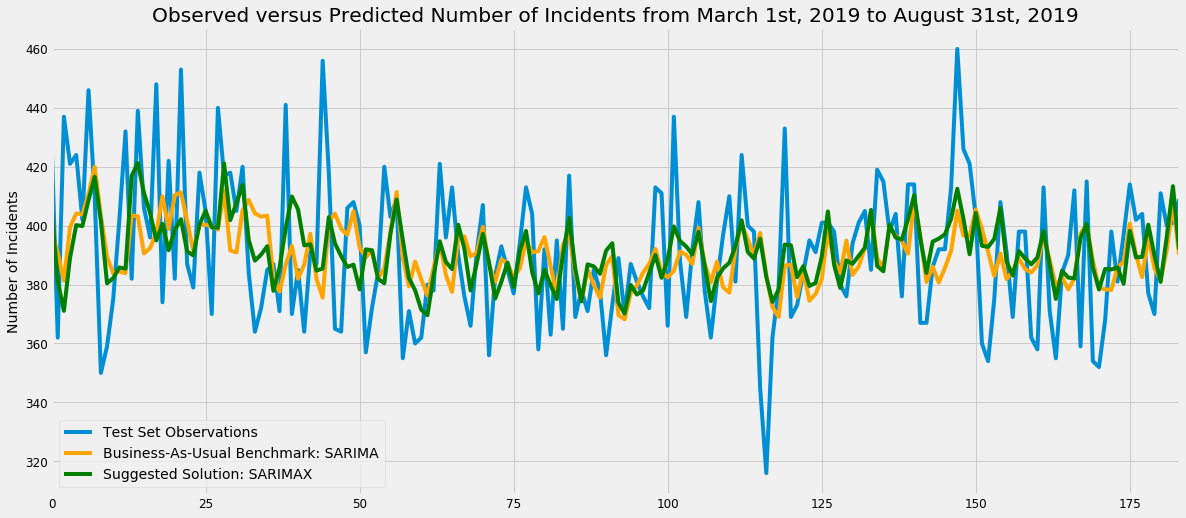

In [76]:
ax = test_name.plot(legend=True,title=title, label='Test Set Observations' )
predictions_u_name.plot(legend=True, label='Business-As-Usual Benchmark: SARIMA',color='orange')
predictions_m_name.plot(legend=True, label='Suggested Solution: SARIMAX',color='green')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [2]:
# Draw the barchart
base_color = sns.color_palette()[0]
dict1_rmse={'Univariate Model':27.375,'Multivariate-Multi-Station Model':22.392}
dict2_rmse={'Univariate Model':27.375,'Multivariate-Single-Station Model':22.713,'Multivariate-Multi-Station Model':22.392}

In [ ]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(7)
ax=sns.barplot(x=list(dict2_rmse.values()), y=list(dict2_rmse.keys()), color=base_color)
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
ax.set_xlabel('RMSE (Root-Mean-Squared-Error)');

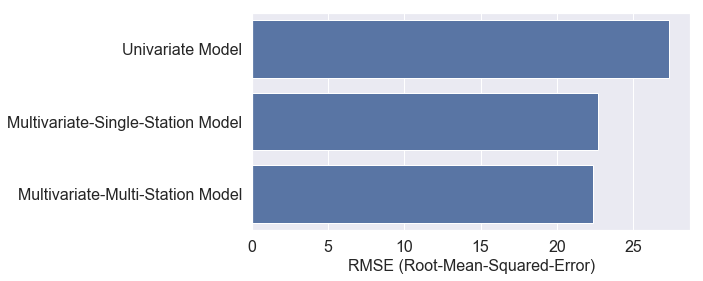

In [6]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(7)
ax=sns.barplot(x=list(dict2_rmse.values()), y=list(dict2_rmse.keys()), color=base_color)
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
ax.set_xlabel('RMSE (Root-Mean-Squared-Error)');